In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
      'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t',
sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.head(3)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1


In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()

In [9]:
dataset['Origin'] = dataset['Origin'].map({1:'USA',2:'Europe',3: 'Japan'})

In [11]:
dataset = pd.get_dummies(dataset, columns = ['Origin'], prefix='', prefix_sep='')

In [12]:
dataset.head(3)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1


In [13]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop (train_dataset.index)

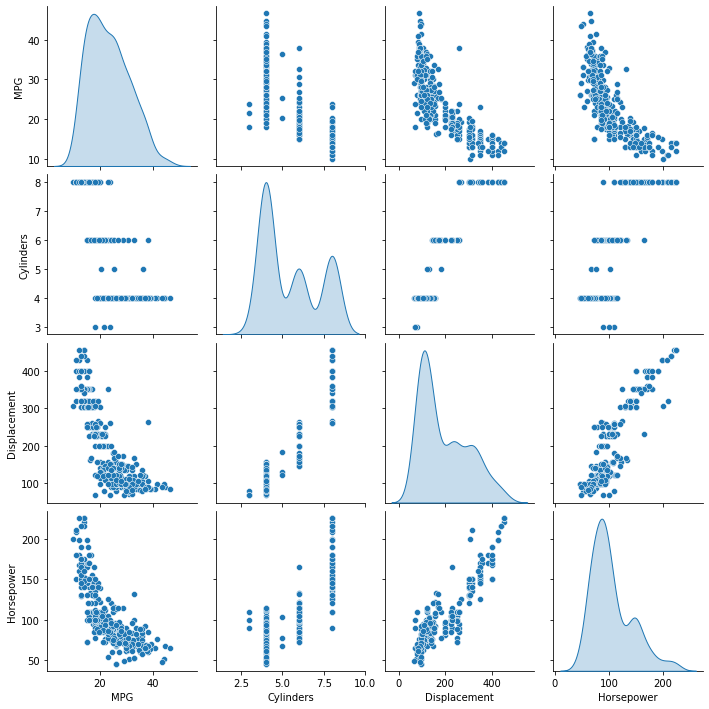

In [14]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement', 'Horsepower']], diag_kind='kde')

In [15]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [34]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [35]:
train_dataset.describe().transpose()[['mean','std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [36]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [38]:
normalizer.adapt(np.array(train_features))

In [39]:
print(normalizer.mean.numpy())

[[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
  1.55592356e+01 7.58980942e+01 1.78343967e-01 1.97452217e-01
  6.24203861e-01]]


In [40]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [41]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [42]:
horsepower_model = tf.keras.Sequential([horsepower_normalizer, layers.Dense(units=1)])

In [43]:
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [44]:
horsepower_model.predict(horsepower[:10])

array([[ 0.1411123 ],
       [ 0.07969636],
       [-0.2604534 ],
       [ 0.19780393],
       [ 0.17890671],
       [ 0.07024775],
       [ 0.21197683],
       [ 0.17890671],
       [ 0.04662624],
       [ 0.07969636]], dtype=float32)

In [45]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [50]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.36 s, sys: 131 ms, total: 3.5 s
Wall time: 5.16 s


In [51]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

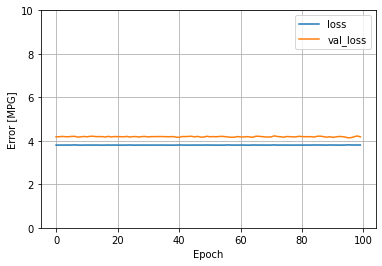

In [52]:
plot_loss(history)

In [53]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [54]:
def plot_horsepower(x,y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x,y, color='r', label ='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

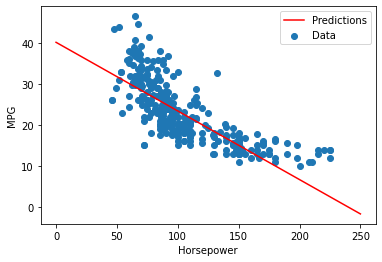

In [55]:
plot_horsepower(x,y)